# Precipitate Growth 

In this problem we are going to be using both the Cahn-Hilliard Equation and Allen-Cahn equation for modelling. 

We are going to assume a AB binary alloy, where $\alpha$ is going to be the super saturated phase.

Diffusivity is assumed to be constant with no Gibbs - Thompson effect.

**Initial Profile**

Again the initial profile is going to be an isolated precipitate $\beta$ phase embedded in a super-saturated matrix of $\alpha$ phase.


**Phase Field Model** 

- Step 1 : We are going to need to atleast two order paramters. The conserved paramter is c for composition and defined as follow 

c = 1; in $\beta$ phase

c = 0; in $\alpha$ phase

The other order parameter is a non-conserved one, $\phi$ which makes sure that Diffusivity is constant, defined as follows 

$\phi$ = 1; in $\beta$ phase

$\phi$ = 0; in $\alpha$ phase

- Step 2 : Writing the free energy functional 

$\mathscr F / N_{v}$ = $\int (f(c,\phi) + k_{c}|\nabla c|^{2} + k_{\phi}|\nabla \phi|^{2})dV$

It is very important to choose the f function here correctly so that it combines both c and $\phi$. 

here, 

$ f(c, \phi) = Ac^{2}(1 - w(\phi)) + B(1-c)^{2}w(\phi) + P\phi^{2}(1 - \phi)^{2}$

where $w(\phi)$ is the Wang Et Al function. 

- Step 3 : Writing the equation
 
We write Cahn-Hilliard equation for c and Allen-Cahn equation for $\phi$.

Let the non - linear functions denote the following :

$h_{c} = \frac{\partial f(c, \phi)}{\partial c} = 2Ac(1-w(\phi)) - 2B(1-c)w(\phi)$

and 

$h_{\phi} = \frac{\partial f(c, \phi)}{\partial \phi} = -Ac^{2}w^{'}(\phi) + 2P\phi(1-\phi)^{2} - 2P\phi(1-\phi)(1-2\phi)$

where 
$w^{'}(\phi)$ is first derivative of Wang Et Al Function.  

Finally the equations become 

$\frac{\partial c}{\partial t} = M\nabla ^{2}(h_{c}(c,\phi)  - 2\kappa_{c}\nabla^{2}c )$

and

$\frac{\partial \phi}{\partial t} = -L(h_{\phi}(c,\phi)  - 2\kappa_{\phi}\nabla^{2}\phi )$

- Step 4 : Solving the PDEs using Fourier Transform
 

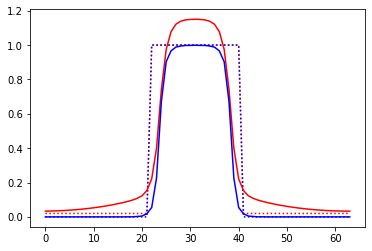

In [2]:
# importing libraries 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline 


N = 64 # no. of grid points 
halfN = N/2
R = 10 # radius of the embedded ppt

c = np.zeros((N,N)) # concentration vector
phi = np.zeros((N,N)) # phi vector

# defining the intital profiles of c and phi 
for i in range (0,N):
    for j in range(0,N):
        
        paramter = (i+1 - halfN) ** 2 + (j+1 - halfN) ** 2
        
        if (paramter <= (R ** 2)):
            c[i][j] = 1.0
            phi[i][j] = 1.0
        else :
            c[i][j] = 0.02
            phi[i][j] = 0.0

cprofile = c[:][int(halfN)]
phiprofile = phi[:][int(halfN)]
# plotting the intital profiles 
plt.plot(cprofile, color = "red", linestyle = "dotted") # concentration - dotted red
plt.plot(phiprofile, color = "blue", linestyle = "dotted") # phi - dotted blue

# wang et al function
def f(x) :
    return x**3 * (10 - 15 * x + 6 * x**2) 

# derivative of wang et al function
def fp(x) :
    return 3 * x**2 * (10 - 15 * x + 6 * x **2) + x ** 3 * (12 * x - 15)

# defining the PDE parameters
delk = 2 * np.pi / N 
dt = 0.5
A = 1.0
B = 1.0
P = 1.0
M = 1.0
kx = 1.0
ky = 1.0
Kappac = 1.0
Kappaphi = 1.0

# non-linear function vectors
hphi = np.zeros((N,N))
hc = np.zeros((N,N))

# non-linear function vectors in reciprocal space
hchat = np.zeros((N,N))
hphihat = np.zeros((N,N))

# fourier transform vector of c and phi
chat = np.zeros((N,N))
phihat = np.zeros((N,N))

for m in range (1,2) : # outer - time loop
    
    for n in range (0, 100) : # inner - time loop 
        
        for i in range (0, N) :
            for j in range (0, N):
            
                w = f(phi[i][j])
                
                if (phi[i][j] < 0) :
                    w = 0.0
                elif (phi[i][j] > 1) :
                    w = 1.0
                # evolving the h_c non linear function 
                hc[i][j] = 2 * A * c[i][j] * (1 - w) - 2 * B * (1 - c[i][j]) * w
        
        for i in range (0, N) :
            for j in range (0, N):
                
                wp = fp(phi[i][j])
                
                if (phi[i][j] < 0):
                    wp = 0.0
                elif (phi[i][j] > 1):
                    wp = 0.0
                # evolving the h_phi non linear function 
                hphi[i][j] = - A * c[i][j]**2 * wp + 2 * B * (1 - c[i][j])**2 * wp + 2 * P * phi[i][j] * (1 - phi[i][j]) * (1 - 2 * phi[i][j])
        # taking fourier transforms
        hchat = np.fft.fft2(hc)
        hphihat = np.fft.fft2(hphi)
        chat = np.fft.fft2(c)
        phihat = np.fft.fft2(phi) 
        
        for i in range (0,N):
            for j in range (0,N):
                
                if (i <= halfN):
                    kx = i * delk
                if (i > halfN):
                    kx = (i - N) * delk
                if (j <= halfN):
                    ky = j * delk
                if (j > halfN):
                    ky = (j - N) * delk 
                
                k2 = kx ** 2 + ky ** 2
                k4 = k2 ** 2
                # cahn - hilliard equation
                chat[i][j] = (chat[i][j] - dt * k2 * hchat[i][j]) / (1 + 2 * k4 * dt)
                # allen - cahn equation
                phihat[i][j] = (phihat[i][j] - dt * hphihat[i][j]) / (1 + 2 * k2 * dt)
        # taking inverse fourier transform         
        c = np.real(np.fft.ifft2(chat)) 
        phi = np.real(np.fft.ifft2(phihat))
# plotting the final profiles 
cprofile = c[:][int(halfN)]
phiprofile = phi[:][int(halfN)]

plt.plot(cprofile, color = "red") # concentration - red
plt.plot(phiprofile,color = "blue") # phi - blue